# 01_04.Logistic Regression(분류)
- 불균형 데이터 처리
- 분류모델검증: https://scikit-learn.org/stable/modules/model_evaluation.html
- 3.3.2. Classification metrics

## 1.기본 package 설정

In [ ]:
# 그래프에서 한글 폰트 인식하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

#  *** 런타임 다시 시작

In [ ]:
## 1.기본
import numpy as np  # numpy 패키지 가져오기
import matplotlib.pyplot as plt # 시각화 패키지 가져오기
import seaborn as sns # 시각화

## 2.데이터 가져오기
import pandas as pd # csv -> dataframe으로 전환

## 3.데이터 전처리
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline                    # 불균형데이터 처리를 위한 pipeline 수정
# from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# 4. 훈련/검증용 데이터 분리
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE                  # 불균형데이터 처리로 수정

## 5.모델구축
# from sklearn import linear_model
# from sklearn.linear_model import Lasso     # 파라미터 튜닝을 위해 lasso 모델로 변경
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀 모델

## 6.모델검정
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import ConfusionMatrixDisplay # 그래프 그리기기
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score  # 정확도, 민감도 등
from sklearn.metrics import roc_curve, auc # ROC 곡선 그리기

# 7.최적화
from sklearn.model_selection import GridSearchCV # 하이퍼파라미터 튜닝

## 2.데이터 불러오기

### 2.1 구글 드라이브와 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.2 데이터 프레임으로 저장
- 원본데이터(csv)를 dataframe 형태로 가져오기(pandas)

In [ ]:
breast_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/유방암진단.csv', encoding="cp949")
breast_df.head()

,id,진단,반지름,질감,주변부,크기,평활도,조밀성,오목,대칭,프랙탈
0,1,1,18.0,10.4,122.8,1001.0,0.118,0.278,0.300,0.242,0.079
1,2,1,20.6,17.8,132.9,1326.0,0.085,0.079,0.087,0.181,0.057
2,3,1,19.7,21.3,130.0,1203.0,0.110,0.160,0.197,0.207,0.060
3,4,0,13.5,14.4,87.5,566.3,0.098,0.081,0.067,0.189,0.058
4,5,0,13.1,15.7,85.6,520.0,0.108,0.127,0.046,0.197,0.068


### 2.3 자료구조 살펴보기

In [ ]:
breast_df.shape

(565, 11)

In [ ]:
breast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      565 non-null    int64  
 1   진단      565 non-null    int64  
 2   반지름     565 non-null    float64
 3   질감      565 non-null    float64
 4   주변부     565 non-null    float64
 5   크기      565 non-null    float64
 6   평활도     565 non-null    float64
 7   조밀성     565 non-null    float64
 8   오목      565 non-null    float64
 9   대칭      565 non-null    float64
 10  프랙탈     565 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 48.7 KB


In [ ]:
breast_df.columns

Index(['id', '진단', '반지름', '질감', '주변부', '크기', '평활도', '조밀성', '오목', '대칭', '프랙탈'], dtype='object')

## 3.데이터 전처리

### 3.1 필요없는 변수 제거

In [ ]:
breast_df = breast_df.drop (['id'], axis=1)
breast_df.head()

,진단,반지름,질감,주변부,크기,평활도,조밀성,오목,대칭,프랙탈
0,1,18.0,10.4,122.8,1001.0,0.118,0.278,0.300,0.242,0.079
1,1,20.6,17.8,132.9,1326.0,0.085,0.079,0.087,0.181,0.057
2,1,19.7,21.3,130.0,1203.0,0.110,0.160,0.197,0.207,0.060
3,0,13.5,14.4,87.5,566.3,0.098,0.081,0.067,0.189,0.058
4,0,13.1,15.7,85.6,520.0,0.108,0.127,0.046,0.197,0.068


### 3.2 범주형 변수 처리
- 가변수 처리시 문자로 처리를 해야 변수명 구분이 쉬움

In [ ]:
breast_df['진단'] = breast_df['진단'].replace ([1,0], ['악성','양성'])  # 중요한 변수를 앞으로 변경

breast_df.head()

,진단,반지름,질감,주변부,크기,평활도,조밀성,오목,대칭,프랙탈
0,악성,18.0,10.4,122.8,1001.0,0.118,0.278,0.300,0.242,0.079
1,악성,20.6,17.8,132.9,1326.0,0.085,0.079,0.087,0.181,0.057
2,악성,19.7,21.3,130.0,1203.0,0.110,0.160,0.197,0.207,0.060
3,양성,13.5,14.4,87.5,566.3,0.098,0.081,0.067,0.189,0.058
4,양성,13.1,15.7,85.6,520.0,0.108,0.127,0.046,0.197,0.068


In [ ]:
breast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   진단      565 non-null    object 
 1   반지름     565 non-null    float64
 2   질감      565 non-null    float64
 3   주변부     565 non-null    float64
 4   크기      565 non-null    float64
 5   평활도     565 non-null    float64
 6   조밀성     565 non-null    float64
 7   오목      565 non-null    float64
 8   대칭      565 non-null    float64
 9   프랙탈     565 non-null    float64
dtypes: float64(9), object(1)
memory usage: 44.3+ KB


## 4.데이터 탐색

### 4.1 EDA 데이터 탐색

In [ ]:
# 수치형 변수
breast_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
반지름,565.0,14.14,3.53,7.00,11.70,13.40,15.90,28.10
질감,565.0,19.29,4.31,9.70,16.20,18.80,21.80,39.30
주변부,565.0,92.03,24.37,43.80,75.20,86.30,104.30,188.50
크기,565.0,655.84,352.94,143.50,419.80,551.10,788.50,2501.00
평활도,565.0,0.10,0.01,0.05,0.09,0.10,0.10,0.16
조밀성,565.0,0.10,0.05,0.02,0.06,0.09,0.13,0.34
오목,565.0,0.09,0.08,0.00,0.03,0.06,0.13,0.43
대칭,565.0,0.18,0.03,0.11,0.16,0.18,0.20,0.30
프랙탈,565.0,0.06,0.01,0.05,0.06,0.06,0.07,0.10


In [ ]:
# 그룹별 분석
breast_df.groupby('진단').mean()

,반지름,질감,주변부,크기,평활도,조밀성,오목,대칭,프랙탈
진단,,,,,,,,,
악성,17.558173,21.652885,115.982692,987.169712,0.103135,0.146577,0.163053,0.193514,0.062712
양성,12.152941,17.916246,78.080392,462.790196,0.092521,0.080104,0.046090,0.174238,0.062877


In [ ]:
# 범주형 변수
# lecture_df.columns
categorical_features=['진단']

for col in categorical_features:
    cat = breast_df[col].value_counts()
    print(cat)

양성    357
악성    208
Name: 진단, dtype: int64


### 4.2 그래프 그리기

In [ ]:
# 한글 폰트 인식
plt.rc('font', family='NanumBarunGothic')

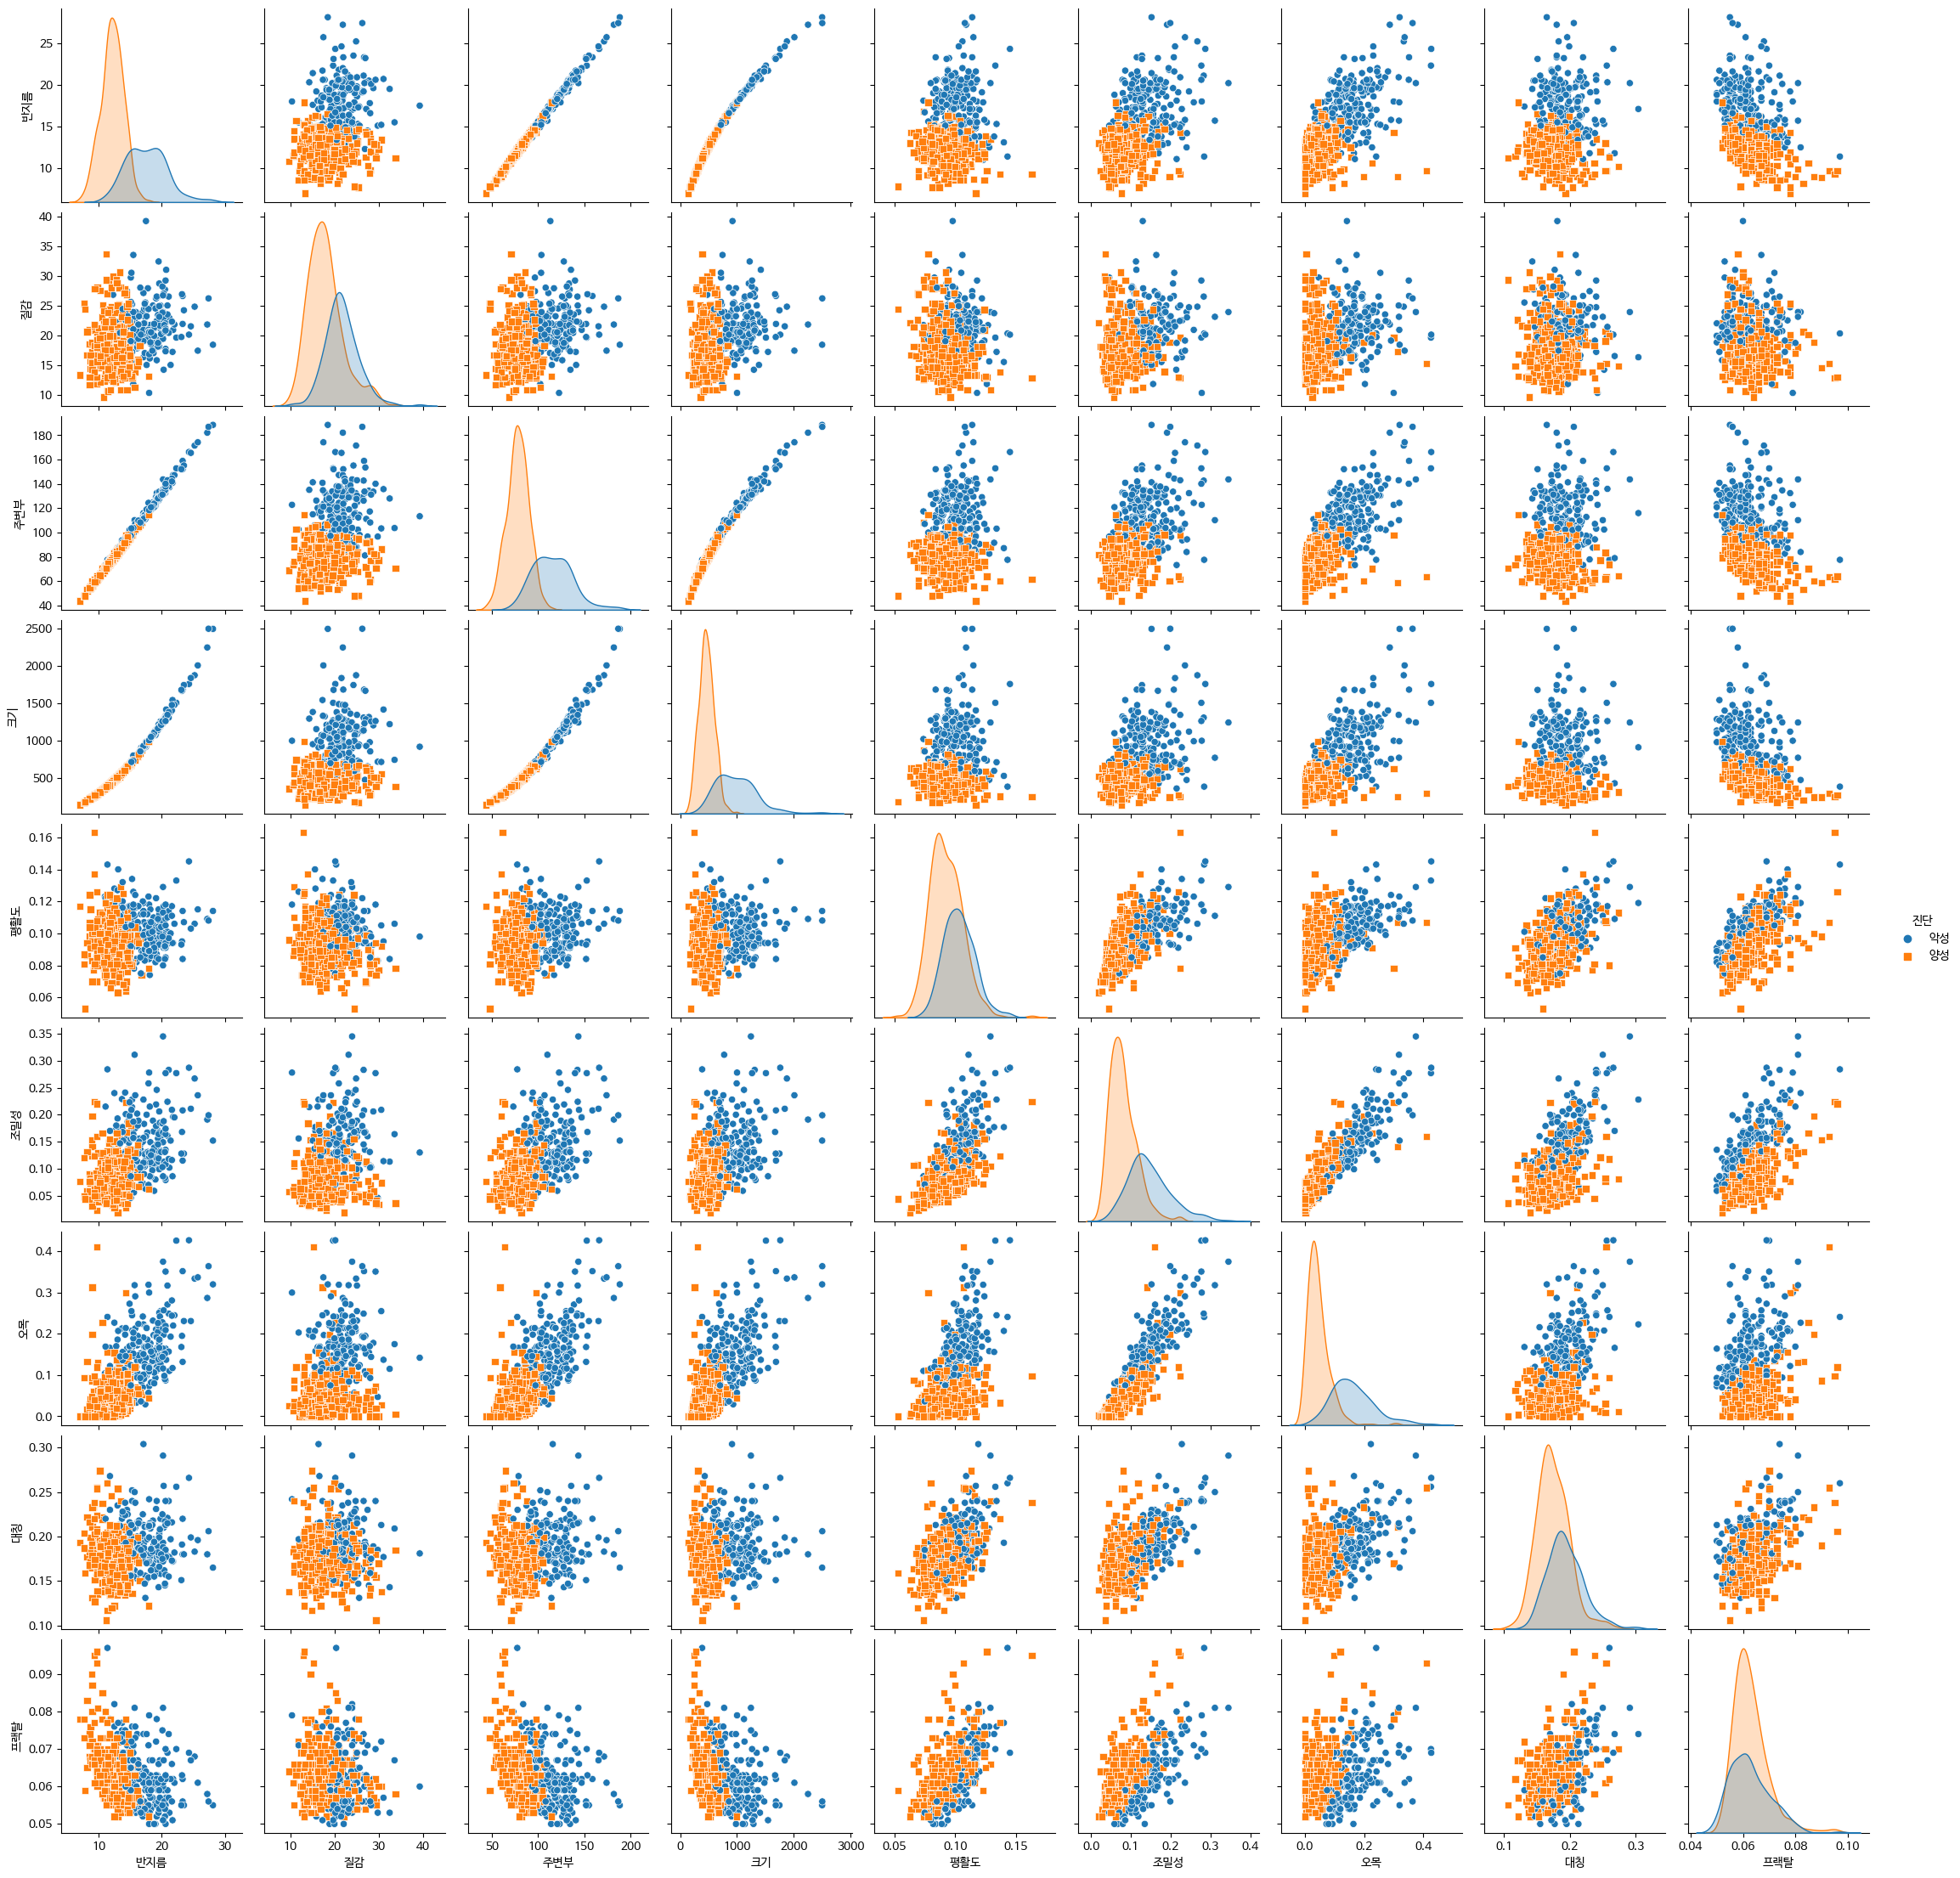

In [ ]:
# 수치형 변수
g = sns.pairplot(breast_df,
                 hue="진단",
                 markers=["o", "s"])

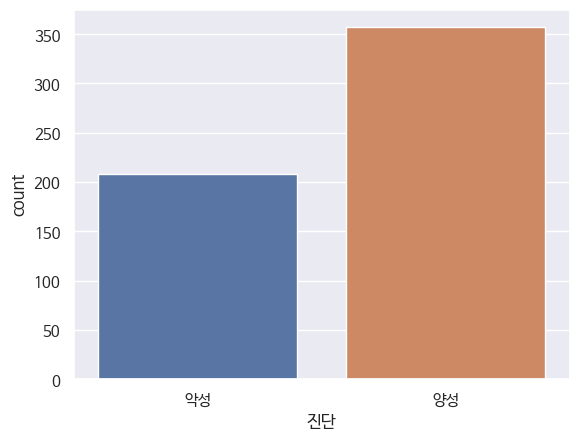

In [ ]:
# 범주형 변수
for col in categorical_features:
    sns.countplot(x=col, data = breast_df)
    plt.show()

### 4.3 base accuracy


In [ ]:
# base accuracy
breast_df['진단'].value_counts()

양성    357
악성    208
Name: 진단, dtype: int64

In [ ]:
breast_df['진단'].value_counts()/breast_df.shape[0]

양성    0.631858
악성    0.368142
Name: 진단, dtype: float64

## 5.훈련/테스트용 데이터 분할


### 5.1 data와 target으로 분리
- data: X, target: y 로 분리

- X 추출


In [ ]:
# X 추출법(3): y값만 제거
X = breast_df.drop (['진단'], axis=1)
X.head()

,반지름,질감,주변부,크기,평활도,조밀성,오목,대칭,프랙탈
0,18.0,10.4,122.8,1001.0,0.118,0.278,0.300,0.242,0.079
1,20.6,17.8,132.9,1326.0,0.085,0.079,0.087,0.181,0.057
2,19.7,21.3,130.0,1203.0,0.110,0.160,0.197,0.207,0.060
3,13.5,14.4,87.5,566.3,0.098,0.081,0.067,0.189,0.058
4,13.1,15.7,85.6,520.0,0.108,0.127,0.046,0.197,0.068


- target(y) 추출
- y 값을 series에서 배열로 변환

In [ ]:
y = breast_df['진단']
y.head()

0    악성
1    악성
2    악성
3    양성
4    양성
Name: 진단, dtype: object

In [ ]:
# y 값을 배열로 변환
# 악성 -> 0, 양성 -> 1로 변경됨

class_le = LabelEncoder()
y = class_le.fit_transform(y)
y

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,

### 5.2 훈련용 및 테스트용 데이터 분할
- test_size: 검증데이터 30%
- random_state : random seed 번호 = 1
- stratify : y(클래스)의 비율에 따라 분할(분류모형일때 사용)

In [ ]:
# \ 이후에 space 없어야 함
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 1,
                                                    stratify = y)        # stratify(분류모형일때 사용)

In [ ]:
X_train.info()

In [ ]:
np.bincount(y_train)

array([145, 250])

In [ ]:
X_test.info()

In [ ]:
np.bincount(y_test)

array([ 63, 107])

## 6.pipeline으로 데이터 전처리
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
- R에서 recipe
- 범주형 변수: OneHotEncoder
- 수치형 변수:
- 선형모델은 StandardScaler 로 표준화
- tree형 모델은 데이터 원형 사용

### 6.1 preprocess 세팅

In [ ]:
# from imblearn.pipeline import Pipeline
# 불균형데이터 처리를 위해 from sklearn.pipeline-> from imblearn.pipeline

In [ ]:
# pipeline으로 세팅
# 수치형 변수(y는 제외)
numeric_features = ['반지름', '질감', '주변부', '크기', '평활도', '조밀성', '오목', '대칭', '프랙탈']

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')), # 누락된 값은 중앙값으로 처리
        ('scaler', StandardScaler())
    ]
)

# 범주형 변수(y는 제외)
categorical_features=[]

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant',
                                  fill_value='missing')),  # 누락된 값은 missing으로 상수 처리
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]
)

# preprocessor로 데이터 변환 세팅
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [ ]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['반지름', '질감', '주변부', '크기', '평활도', '조밀성', '오목',
                                  '대칭', '프랙탈']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 [])])

### 6.2 데이터 전처리 결과 확인
- https://www.kaggle.com/code/thomasswain/titanic-classifier

In [ ]:
pd.DataFrame(preprocessor.fit_transform(X_train)).head()

,0,1,2,3,4,5,6,7,8
0,-0.377192,-0.436613,-0.364480,-0.414277,-1.207938,-0.311324,-0.212350,-0.923909,-0.698111
1,-1.768867,1.403965,-1.747517,-1.302799,-1.137325,-1.056841,-1.099694,0.197615,1.403672
2,-0.786508,-1.471938,-0.793970,-0.738675,0.063105,-0.553617,-0.703987,-0.176226,0.002483
3,-0.868372,-0.597664,-0.845194,-0.778585,0.769240,-0.516341,-0.739960,-0.400531,0.002483
4,-0.186178,-1.149837,-0.191108,-0.257876,0.063105,-0.460428,-0.296288,0.272384,-0.698111


## 7.모델만들기 (모델 설정)
- R에서 workflow
- 예측모델: 000_reg
- 분류모델: 000_clf

### 7.1 pipeline으로 모델 연결

In [ ]:
#from imblearn.over_sampling import SMOTE                  # 불균형데이터 처리로 수정

lr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ('smote', SMOTE(sampling_strategy=0.75)),
        ("lr_clf", LogisticRegression())                   # lr_reg --> lr_clf
    ]
)

lr_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['반지름', '질감', '주변부', '크기',
                                                   '평활도', '조밀성', '오목', '대칭',
                                                   '프랙탈']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('smote', SMOTE(sampling_strategy=0.75)),
                ('lr_clf', LogisticRegression())])

### 7.2 하이퍼파라미터 세팅
- 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝
- 기계학습 모델의 성능을 결정하는 하이퍼 파라미터 튜닝

In [ ]:
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'smote', 'lr_clf', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__keep_empty_features', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__c

In [ ]:
lr_grid = {
    'lr_clf__C': np.logspace(-5, -1, 5),      # 정규화 강도의 역수 [1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]
}

lr_grid

{'lr_clf__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}

### 7.3 하이퍼파라미터 그리드 만들기

In [ ]:
lr_gs = GridSearchCV(estimator = lr_pipe,
                       param_grid = lr_grid,
                       scoring='roc_auc',             # roc_auc
                       cv = 10,
                       n_jobs = -1,
                       verbose = 10,              # 프로세스 진행사항 확인
                       return_train_score = True) # 훈련결과 저장

## 8.모델 훈련(모델 학습)
- machine learning

### 8.1 모델 훈련하기(learning)

In [ ]:
lr_gs.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['반지름',
                                                                          '질감',
                                                                          '주변부',
                                                                          '크기',
                                                                          '평활도',
                                                                          '조밀성',
                                                                          '오목',
                                                                          '대칭',
                                                                          '프랙탈']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [])])),
                                       ('smote', SMOTE(sampling_strategy=0.75)),
                                       ('lr_clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr_clf__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])},
             return_train_score=True, scoring='roc_auc', verbose=10)

### 8.2 검증 곡선으로 Tuning 결과 확인
- 결과 표로 정리: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#sphx-glr-auto-examples-model-selection-plot-grid-search-stats-py
- 그래프로 정리: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv

In [ ]:
# 결과확인
lr_gs.cv_results_

{'mean_fit_time': array([0.02065315, 0.01650636, 0.01420898, 0.01382153, 0.01440959]),
 'std_fit_time': array([0.00761417, 0.00616046, 0.00230714, 0.00213043, 0.00088672]),
 'mean_score_time': array([0.00840971, 0.00501769, 0.00483973, 0.00613933, 0.00487738]),
 'std_score_time': array([0.00538198, 0.00061449, 0.00021006, 0.00388215, 0.00013983]),
 'param_lr_clf__C': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'lr_clf__C': 1e-05},
  {'lr_clf__C': 0.0001},
  {'lr_clf__C': 0.001},
  {'lr_clf__C': 0.01},
  {'lr_clf__C': 0.1}],
 'split0_test_score': array([0.99466667, 0.99466667, 0.992     , 0.99466667, 0.99466667]),
 'split1_test_score': array([0.99466667, 0.99466667, 0.99466667, 1.        , 0.99466667]),
 'split2_test_score': array([0.99466667, 0.99466667, 0.99466667, 0.99466667, 0.99466667]),
 'split3_test_score': array([0.97066667, 0.97066667, 0.97066667, 0.

In [ ]:
# 분석결과를 표로 정리
results_df = pd.DataFrame(lr_gs.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
4,{'lr_clf__C': 0.1},1,0.993733,0.005101
3,{'lr_clf__C': 0.01},2,0.991790,0.008415
1,{'lr_clf__C': 0.0001},3,0.990971,0.008278
2,{'lr_clf__C': 0.001},4,0.990705,0.008197
0,{'lr_clf__C': 1e-05},5,0.990686,0.008596


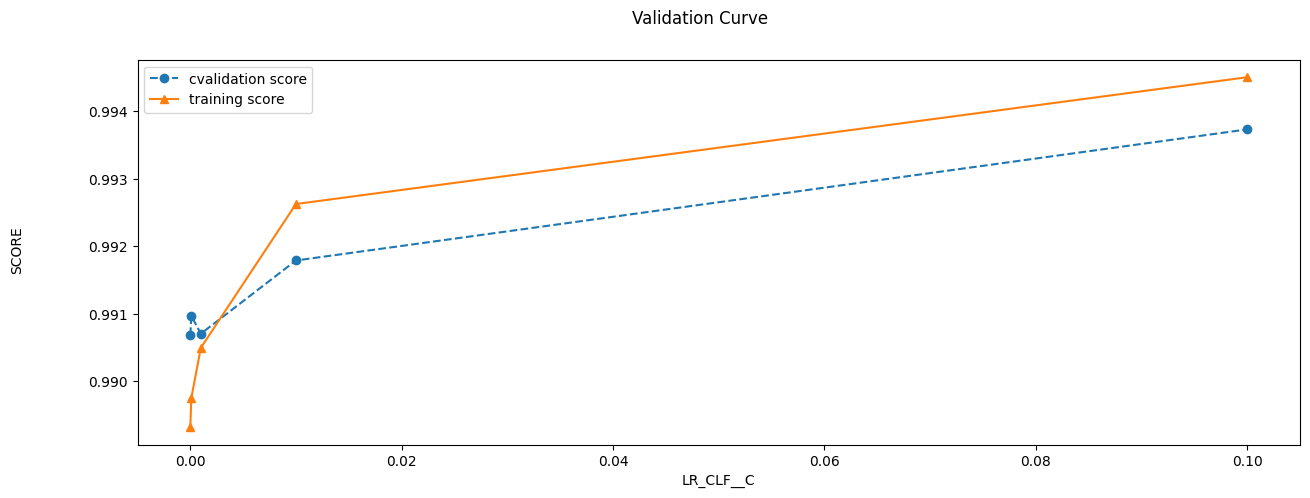

In [ ]:
# 튜닝결과 그래프
results = lr_gs.cv_results_
means_test = results['mean_test_score']
means_train = results['mean_train_score']

masks = []
masks_names = list(lr_gs.best_params_.keys())
for p_k, p_v in lr_gs.best_params_.items():
    masks.append(list(results['param_'+p_k].data==p_v))

params = lr_gs.param_grid

fig, ax = plt.subplots(1,len(params),
                       sharex='none',
                       sharey='all',
                       figsize=(15,5))
fig.suptitle('Validation Curve')
fig.text(0.04, 0.5, 'SCORE', va='center', rotation='vertical')
pram_preformace_in_best = {}

for i, p in enumerate(masks_names):
    # parameter 값이 1개 여서 수정
    # masks [i+1:]-> masks [i:]
    m = np.stack(masks[:i] + masks[i:])
    pram_preformace_in_best
    best_parms_mask = m.all(axis=0)
    best_index = np.where(best_parms_mask)[0]
    x = np.array(params[p])
    # y_1, y_2 수정
    # means_test[best_index]-> means_test
    # means_test[best_index]-> means_train
    y_1 = np.array(means_test)
    y_2 = np.array(means_train)
    # ax 수정
    #  ax[i]-> ax
    ax.errorbar(x, y_1, linestyle='--', marker='o', label='cvalidation score')
    ax.errorbar(x, y_2, linestyle='-', marker='^',label='training score' )
    ax.set_xlabel(p.upper())

plt.legend()
plt.show()

### 8.3 best 모델 설정

In [ ]:
# best 모델 파라미터 확인
print(lr_gs.best_score_)
print(lr_gs.best_params_)

0.9937333333333334
{'lr_clf__C': 0.1}


In [ ]:
# best 모델 파라미터를 최종모델로 훈련
best_clf = lr_gs.best_estimator_
best_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['반지름', '질감', '주변부', '크기',
                                                   '평활도', '조밀성', '오목', '대칭',
                                                   '프랙탈']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('smote', SMOTE(sampling_strategy=0.75)),
                ('lr_clf', LogisticRegression(C=0.1))])

In [ ]:
print(best_clf['lr_clf'])

LogisticRegression(C=0.1)


### 8.4 중요변수확인

In [ ]:
# 중요도 점수 계산
feature = best_clf['preprocessor'].get_feature_names_out()    # 수정
importances = best_clf["lr_clf"].coef_                        # 수정
importances = importances.flatten()                           # flatten() - 다차원 array를 1차원 array로 변환
output = pd.DataFrame([feature , importances],
                      index = ["feature","importances"]).T
# output = output[output.importances > 0]
output.sort_values(["importances"],
                   ascending = True ,                         #ascending = True
                   inplace = True)
output

,feature,importances
6,num__오목,-0.881982
0,num__반지름,-0.869159
2,num__주변부,-0.856802
1,num__질감,-0.80356
3,num__크기,-0.799557
5,num__조밀성,-0.57653
4,num__평활도,-0.555297
7,num__대칭,-0.332879
8,num__프랙탈,0.302631


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


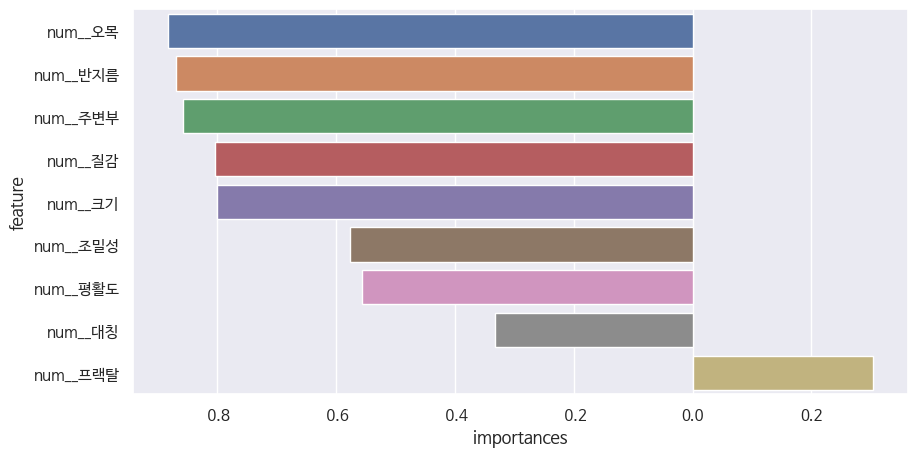

In [ ]:
# 그래프 그리기

plt.rc('font', family='NanumBarunGothic')

fig ,ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale = 1)
ax = sns.barplot(y="feature", x="importances", data=output)
plt.show()

## 9.모델 test 및 검정

### 9.1 검증용 데이터로 예측
- predict_proba (확률값으로 표시): 분류모델에서 사용
- predict (class로 표시)

In [ ]:
y_pred = best_clf.predict_proba(X_test)
y_pred

In [ ]:
y_pred = best_clf.predict(X_test)
y_pred

array([0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0])

### 9.2 정오분류표 검정

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels = best_clf.classes_)
cm

array([[ 55,   8],
       [  5, 102]])

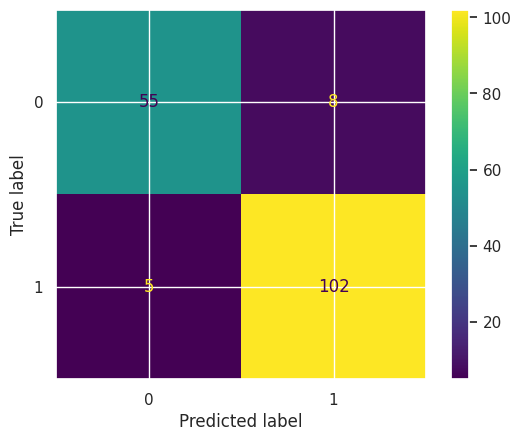

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_clf.classes_)
disp.plot()
plt.show()

### 9.3 모델 검정

In [ ]:
## 6.모델검정
#from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
#from sklearn.metrics import ConfusionMatrixDisplay # 그래프 그리기기
#from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score  # 정확도, 민감도 등
#from sklearn.metrics import roc_curve, auc # ROC 곡선 그리기

In [ ]:
print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        63
           1       0.93      0.95      0.94       107

    accuracy                           0.92       170
   macro avg       0.92      0.91      0.92       170
weighted avg       0.92      0.92      0.92       170



In [ ]:
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('roc_auc: %.3f' % roc_auc_score(y_test, y_pred))
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 13
roc_auc: 0.913
정확도: 0.924
정밀도: 0.927
재현율: 0.953
F1: 0.940


### 9.4 ROC 곡선 그리기

In [ ]:
# fpr, tpr, thresholds = roc_curve(y_test, best_clf.decision_function(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_clf.predict_proba(X_test)[:, 1])

In [ ]:
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , 0.01587302, 0.01587302,
        0.03174603, 0.03174603, 0.04761905, 0.04761905, 0.07936508,
        0.07936508, 0.11111111, 0.11111111, 0.12698413, 0.12698413,
        0.26984127, 0.26984127, 0.34920635, 0.34920635, 1.        ]),
 array([0.        , 0.00934579, 0.71962617, 0.71962617, 0.8411215 ,
        0.8411215 , 0.88785047, 0.88785047, 0.91588785, 0.91588785,
        0.92523364, 0.92523364, 0.93457944, 0.93457944, 0.98130841,
        0.98130841, 0.99065421, 0.99065421, 1.        , 1.        ]),
 array([1.99931490e+00, 9.99314904e-01, 9.08263949e-01, 9.07967129e-01,
        8.33698367e-01, 8.32910417e-01, 7.85827619e-01, 7.77019461e-01,
        7.15830021e-01, 7.04933033e-01, 6.98169170e-01, 6.07594720e-01,
        5.73964023e-01, 5.70420953e-01, 4.73921354e-01, 2.05398006e-01,
        1.86653089e-01, 1.54043051e-01, 1.36348370e-01, 4.99463404e-05]))

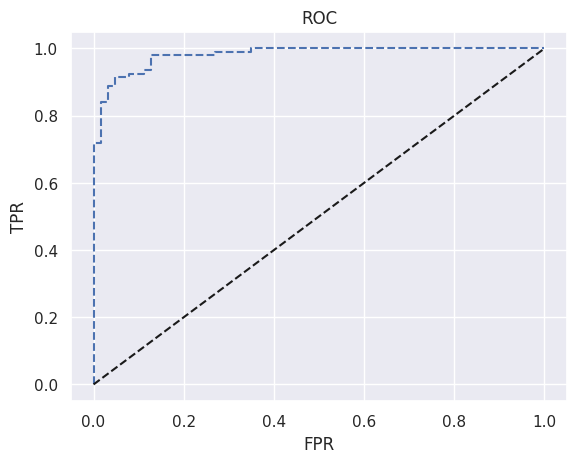

In [ ]:
plt.plot(fpr, tpr, '--', label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC CURVE')
plt.show()

### 9.5 gain and lift chart
- scikit-plot 설치 및 사용
- https://scikit-plot.readthedocs.io/en/stable/metrics.html
- pip install scikit-plot

In [ ]:
pip install scikit-plot

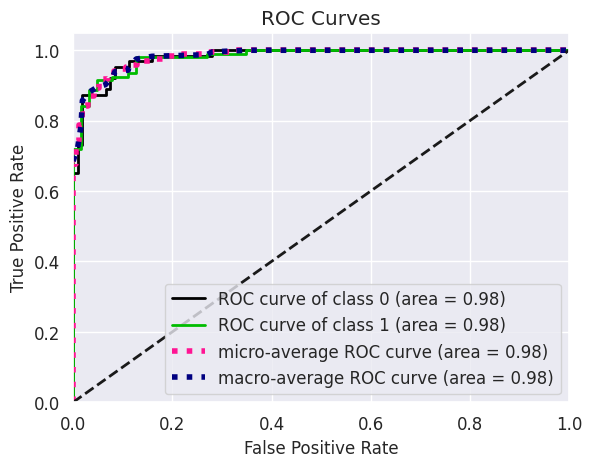

In [ ]:
# ROC_ACU Cruve
import scikitplot as skplt
skplt.metrics.plot_roc(y_test,
                       best_clf.predict_proba(X_test))
plt.show()

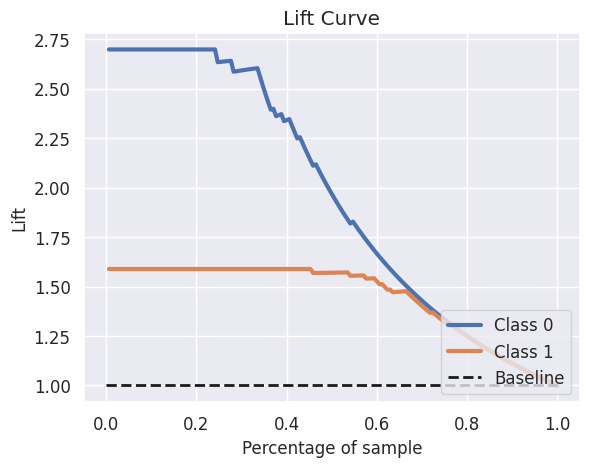

In [ ]:
# lift Chart
skplt.metrics.plot_lift_curve(y_test,
                              best_clf.predict_proba(X_test))
plt.show()

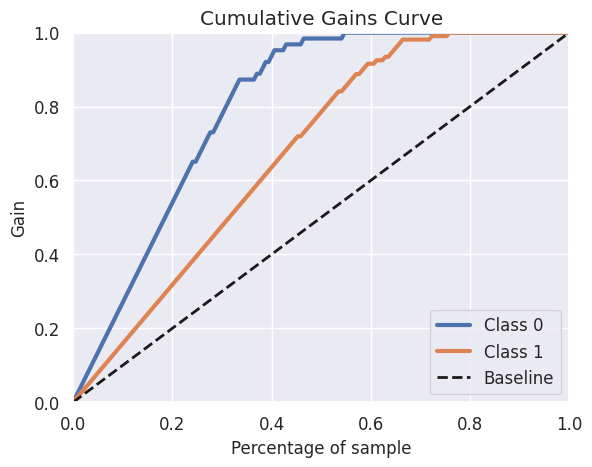

In [ ]:
# gain Chart
skplt.metrics.plot_cumulative_gain(y_test,
                                   best_clf.predict_proba(X_test))
plt.show()